In [ ]:
from .tacotron import Tacotron

def create_model(name, hparams):
    if name == 'tacotron':
        return Tacotron(hparams)
    else:
        raise Exception('Unknown model: ' + name)

## Model

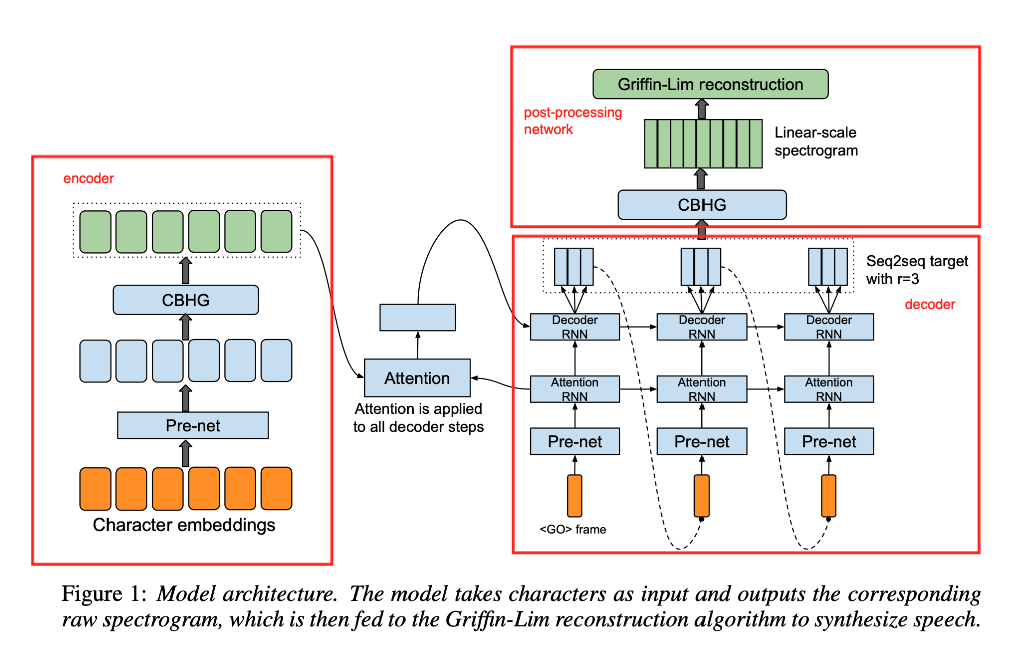

通常我们将RNN的输入称为'context(上下文)'，我们希望通过encoder来产生此上下文的向量。

### 1. Character Embedding

将文本转为one-hot向量，embedding之后的shape:[N, T, 256], 256为word_dim

In [ ]:
from text.symbols import symbols

class Tacotron():
    def __init__(self, hparams):
        self._hparams = hparams

    def initialize(self, inputs, input_lengths, mel_targets=None, linear_targets=None):
        '''
        Initializes the model for inference.
        Sets "mel_outputs", "linear_outputs", and "alignments" fields.
        Args:
          inputs: int32 Tensor with shape [N, T_in] where N is batch size, T_in is number of steps in the input time series, and values are character IDs
          input_lengths: int32 Tensor with shape [N] where N is batch size and values are the lengths of each sequence in inputs.
          mel_targets: float32 Tensor with shape [N, T_out, M] where N is batch size, T_out is number of steps in the output time series, M is num_mels, 
                       and values are entries in the mel spectrogram. Only needed for training.
          linear_targets: float32 Tensor with shape [N, T_out, F] where N is batch_size, T_out is number of steps in the output time series, F is num_freq, 
                       and values are entries in the linear spectrogram. Only needed for training.
        '''
        with tf.variable_scope('inference') as scope:
            is_training = linear_targets is not None
            batch_size = tf.shape(inputs)[0]
            hp = self._hparams

        # Embeddings
        embedding_table = tf.get_variable('embedding', [len(symbols), hp.embed_depth], dtype=tf.float32,
        initializer=tf.truncated_normal_initializer(stddev=0.5))
        embedded_inputs = tf.nn.embedding_lookup(embedding_table, inputs)   # [N, T_in, embed_depth=256]

### 2. Pre-net

pre-net是一个3层的网络结构，其主要功能是对输入进行一系列的非线性的变换，这样有助于模型收敛和泛化。

它有两个隐藏层，层与层之间的连接均是全连接；第一层的隐藏单元数目与输入单元数目一致[N,T,256]->[N,T,256]，第二层的隐藏单元数目为第一层的一半[N,T,256]->[N,T,128]；两个隐藏层采用的激活函数均为ReLu，并保持0.5的dropout来提高泛化能力。

基于tensorflow实现prenet的代码：

In [ ]:
# Encoder
#hp.prenet_depths=[256, 128]
prenet_outputs = prenet(embedded_inputs, is_training, hp.prenet_depths)    # [N, T_in, prenet_depths[-1]=128]

def prenet(inputs, is_training, layer_sizes, scope=None):
    '''Args:
    inputs:输入的tensor,[N,T,256],其中N：batchsize T:输入文本长度
    is_training:布尔值
    layer_size:prenet一共有两层隐藏层,第一层为256个hidden units,第二层为128个hidden units
    '''
    x = inputs
    drop_rate = 0.5 if is_training else 0.0
    with tf.variable_scope(scope or 'prenet'):
        for i, size in enumerate(layer_sizes):
        dense = tf.layers.dense(x, units=size, activation=tf.nn.relu, name='dense_%d' % (i+1))
        x = tf.layers.dropout(dense, rate=drop_rate, training=is_training, name='dropout_%d' % (i+1))
    return x

### 3. Encoder_cbhg

encoder_cbhg是输入端的cbhg,包括convolution bank, hignway network, BiGRU. CBHG最初源于机器翻译，主要用于提高模型的泛化能力。结构如下：

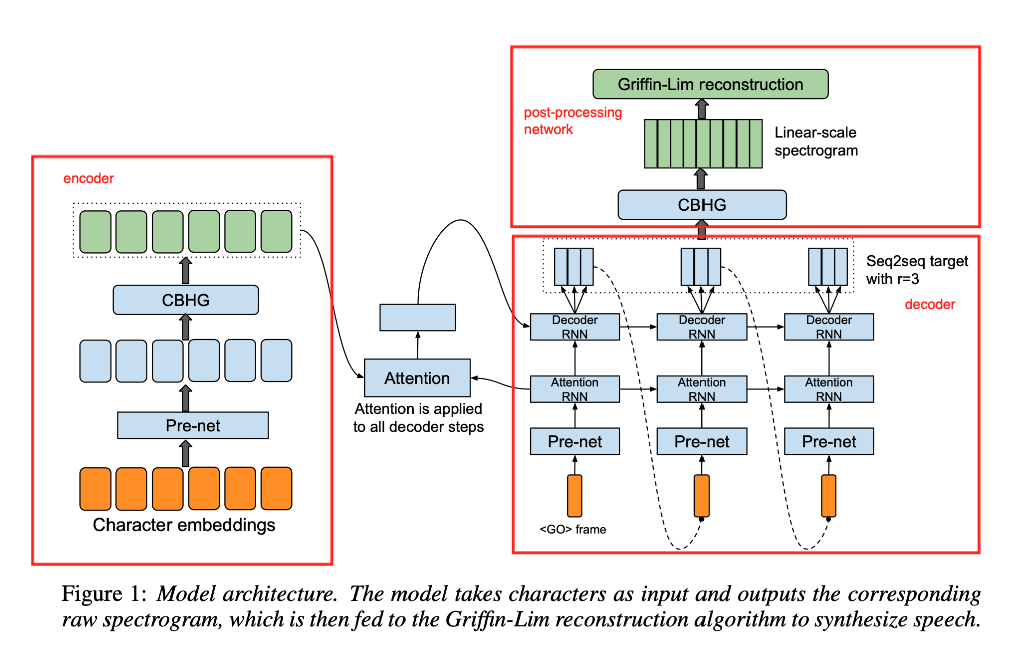

#### 3.1 Convolution Bank

这部分对于特征提取的思路是用 height=1, width=word_dim 的 filter 过滤得到一个 input_embedding 的特征值，然后相邻两个 word 一起过滤得到局部窗口为2的上下文特征值，即 2-gram,一直提取到 16-gram. 128个 filter 用于关注不同的特征值。

- 是 n-gram 的思想

- encoder_cbhg 使用的 kernel_size 为 [1,2,...,16] filter_size=128

- 每个 conv1d 结果按照 axis=-1 拼接起来后的 shape 为 [N, T, 128 \* 16]

#### 3.2 Maxpool1d

maxpool相当于特征筛选，挑选出相邻两个时间步更加突出的特征(更大的值),shape 为 [N, T, 128 \* 16]

#### 3.3 projection

对于encoder_cbhg projections = [128,input_channels] 由于 encoder_cbhg 的输入为 prenet [N, T,128]而 input_channels = inputs.get_shape()[2] 故而 encoder_cbhg projections = [128,128]

#### 3.4 residual connection

残差网络思想 [N, T, 128]

#### 3.5 HighWay Net

把输入同时放入到两个一层的全连接网络中，这两个网络的激活函数分别采用了ReLu和sigmoid函数，假定输入为input，ReLu的输出为output1，sigmoid的输出为output2，那么highway layer的输出为：output=output1∗output2+input∗（1−output2).

#### 3.6 BiGRU

双向拼接，所以shape=[N, T, 256]

In [ ]:
def highwaynet(inputs, scope, depth):
    with tf.variable_scope(scope):
        H = tf.layers.dense(inputs, units=depth, activation=tf.nn.relu, name='H')
        T = tf.layers.dense(inputs, units=depth, activation=tf.nn.sigmoid, name='T', bias_initializer=tf.constant_initializer(-1.0))
        return H * T + inputs * (1.0 - T)

In [ ]:
encoder_outputs = encoder_cbhg(prenet_outputs, input_lengths, is_training, hp.encoder_depth)  # encoder_outputs=[N, T, encoder_depth=256]

def encoder_cbhg(inputs, input_lengths, is_training, depth):
    input_channels = inputs.get_shape()[2]
    return cbhg(inputs, input_lengths, is_training, scope='encoder_cbhg', K=16, projections=[128, input_channels], depth=depth)

def cbhg(inputs, input_lengths, is_training, scope, K, projections, depth):
    '''
    Args:
        inputs:输入的tensor(也是pre-net的输出) [N, T, 128]
        input_lengths:输入的文本的长度,形状为[N],代表一个batch中每一条文本的长度组成的向量
        is_training:布尔值
        K:int,代表第一层卷积里卷积核的个数
        projections:代表第二个卷积层中每次卷积之后的输出长度
    '''
    with tf.variable_scope(scope):
        with tf.variable_scope('conv_bank'):
        # Convolution bank: concatenate on the last axis to stack channels from all convolutions
        conv_outputs = tf.concat([conv1d(inputs, k, 128, tf.nn.relu, is_training, 'conv1d_%d' % k) for k in range(1, K+1)], axis=-1) #K=16

    # Maxpooling:
    maxpool_output = tf.layers.max_pooling1d(conv_outputs, pool_size=2, strides=1, padding='same') #[N,T,128*16]

    # Two projection layers:
    proj1_output = conv1d(maxpool_output, 3, projections[0], tf.nn.relu, is_training, 'proj_1')
    proj2_output = conv1d(proj1_output, 3, projections[1], None, is_training, 'proj_2') # proj2 没有采用激活函数

    # Residual connection:
    highway_input = proj2_output + inputs

    half_depth = depth // 2
    assert half_depth*2 == depth, 'encoder and postnet depths must be even.'

    # Handle dimensionality mismatch:
    if highway_input.shape[2] != half_depth:
        highway_input = tf.layers.dense(highway_input, half_depth)

    # 4-layer HighwayNet:
    for i in range(4):
        highway_input = highwaynet(highway_input, 'highway_%d' % (i+1), half_depth)
    rnn_input = highway_input

    # Bidirectional RNN
    outputs, states = tf.nn.bidirectional_dynamic_rnn(GRUCell(half_depth), GRUCell(half_depth), rnn_input, sequence_length=input_lengths, dtype=tf.float32)
    return tf.concat(outputs, axis=2)  # Concat forward and backward

In [ ]:
def conv1d(inputs, kernel_size, channels, activation, is_training, scope):
    with tf.variable_scope(scope):
        conv1d_output = tf.layers.conv1d(inputs, filters=channels, kernel_size=kernel_size, activation=activation, padding='same')
        return tf.layers.batch_normalization(conv1d_output, training=is_training)

### 4. Attention (BahdanauAttention)

In [ ]:
attention_cell = AttentionWrapper(GRUCell(hp.attention_depth),BahdanauAttention(hp.attention_depth, encoder_outputs),
                                  alignment_history=True, output_attention=False)                                                  # [N, T_in, attention_depth=256]

### 5. Decoder

Apply prenet before concatenation in AttentionWrapper.

In [ ]:
attention_cell = DecoderPrenetWrapper(attention_cell, is_training, hp.prenet_depths)

In [ ]:
class DecoderPrenetWrapper(RNNCell):
    '''Runs RNN inputs through a prenet before sending them to the cell.'''
    def __init__(self, cell, is_training, layer_sizes):
        super(DecoderPrenetWrapper, self).__init__()
        self._cell = cell
        self._is_training = is_training
        self._layer_sizes = layer_sizes

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return self._cell.output_size

    def call(self, inputs, state):
        prenet_out = prenet(inputs, self._is_training, self._layer_sizes, scope='decoder_prenet')
        return self._cell(prenet_out, state)

    def zero_state(self, batch_size, dtype):
        return self._cell.zero_state(batch_size, dtype)